In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import glob
sys.path.append("../../code")
sys.path.append("../../analysis")

In [285]:
import warnings
warnings.filterwarnings('ignore')

In [286]:
import loaders.losaltos as lla

In [287]:
data_dir = os.path.join("../../data/clean_data/")

In [288]:
ripa2023 = lla.load_ripa_data(glob.glob(os.path.join(data_dir, "LAPD_RIPA_DATA*.csv")), dir=".")
ripa2023 = ripa2023.reset_index(drop=True)


In [314]:
ripa2023 = ripa2023.loc[ripa2023['reasonForStopDetail'] == 'Moving Violation']
ripa2023 = ripa2023.reset_index(drop=True)

In [316]:
def simplify_speed(r, explanation, type, text_crime):
    length = len(explanation)
    crime = [] 
    if type == 1:
        for i in range(length):
            if i-1<0 or not explanation[i-1].isdigit():
                if explanation[i].isdigit() and (i+1 <= length and explanation[i+1].isdigit()) and (i+2 >= length or not explanation[i+2].isdigit()) :
                    crime.append(int(explanation[i:i+2]))
    elif type == 2:
        for i in range(len(text_crime)):
            if text_crime[i-1] == ",": 
                comma_place = i-1
        crime.append(int(text_crime[0:comma_place]))
        crime.append(int(text_crime[len(text_crime)-2:]))
    return crime




#if len(crime)==0 and ("speed" in explanation.lower()):
        #crime.append("Speeding")
        

In [317]:
#this is how far above or below the speed limit the person was
def speed_violation(speed):
    d = abs(speed[0] - speed[1])
    return d 


In [318]:
def contains_numbers(explanation ):
    length = len(explanation)
    for i in range(length):
        if explanation[i].isdigit() == True:
            return True
    return False
        

In [319]:
def simplify_race(race):
    if race.lower() in ["white", "asian", "black", "hispanic", "other"]:
        return race
    elif "black" in race.lower():
        return "Black"
    elif "hispanic" in race.lower():
        return "Hispanic"
    elif "asian" in race.lower():
        return "Asian"
    else:
        return "Other"

In [320]:
def simplify_outcome(outcome):
    if outcome == "No Action":
        return "No Action"
    elif "warning" in outcome.lower():
        return "Warning"
    elif ("citation" in outcome.lower()) or ("cite" in outcome.lower()):
        return "Citation"
    elif "arrest" in outcome.lower():
        return "Arrest"
    else:
        return "Other"

In [321]:

def simplify_for_graph_1(race, df):
    race_df = df.loc[(df['simple_race'] == race)]
    race_df = race_df.reset_index(drop=True)
    warnings = race_df.loc[(race_df['simple_result'] == 'Warning')]
    citations = race_df.loc[(race_df['simple_result'] == 'Citation')]
    if len(citations.index) != 0 or len(warnings.index) != 0:
        percent_warnings = round(len(warnings.index) / (len(warnings.index) + len(citations.index)), 3)
    else: 
        percent_warnings = ('N/A')
    data = []
    data.append(percent_warnings)
    data.append(len(warnings.index) + len(citations.index))
    
    
    return data

In [326]:
#Used this to generate two .csvs, which I manually categorized into 3 types. 
#1 means it can be done normally
#2 means that it had to be done manually because it had multiple speeds, or it only stated the road, not the speed
#3 means that it can't be done (no speeding information)/is a different crime

#generating first file 
#mph = ripa2023.loc[ripa2023.reasonForStopExplanation.str.contains("mph")]
#mph = mph.reset_index(drop=True)
#mph.to_csv('mph.csv', index=True)

#making sure there are no duplicate rows
ripa2023 = ripa2023.loc[(ripa2023.reasonForStopExplanation.str.contains("mph")) == False]
ripa2023 = ripa2023.reset_index(drop=True)

#generating the ripa2023_numbers.csv file
#ripa2023_numbers = ripa2023
#ripa2023_numbers = ripa2023_numbers.reset_index(drop=True)
#b=0
#for i in range(len(ripa2023_numbers.index)):
#    a = ripa2023_numbers.iloc[(i-b), 23]
#    if contains_numbers(a) == False:
#        ripa2023_numbers = ripa2023_numbers.drop(i)
#        b+=1
#ripa2023_numbers = ripa2023_numbers.reset_index(drop=True)
#ripa2023_numbers.to_csv('ripa2023_numbers.csv', index=True)

#making sure there aree no duplicate rows
b=0
for i in range(len(ripa2023.index)):
    a = ripa2023.iloc[(i-b), 23]
    if contains_numbers(a) == True:
        ripa2023 = ripa2023.drop(i)
        b+=1
ripa2023 = ripa2023.reset_index(drop=True)

#loading the two dataframes that I categorized by hand for the simplify speed sort that I do later
mph_categorized = pd.read_csv(os.path.join(data_dir, "mph_categorized.csv"),encoding = 'utf-8-sig', engine ='python', skipinitialspace=True, encoding_errors="replace")
numbers_categorized = pd.read_csv(os.path.join(data_dir, "numbers_categorized.csv"),encoding = 'utf-8-sig', engine ='python', skipinitialspace=True, encoding_errors="replace")

In [337]:
#combining above dataframes
frames = [mph_categorized, numbers_categorized]
ripa2023_new = pd.concat(frames)
ripa2023_new = ripa2023_new.reset_index(drop=True)

#getting rid of type 3 
ripa2023_new = ripa2023_new.loc[(ripa2023_new['Type'] != 3)]
ripa2023_new = ripa2023_new.reset_index(drop = True)

#getting the speed and speed limit for the rest
for i in range(len(ripa2023_new.index)):
    x = ripa2023_new.iloc[(i), 24]
    y = ripa2023_new.iloc[(i), 27]
    z = ripa2023_new.iloc[(i), 28]
    ripa2023_new.at[i, 'speed'] = simplify_speed(i,x,y,z)





In [338]:
#creating "speeding" dataframe to take all the speeding crimes that did not contain the extent of the violation of the speed limit
speeding = ripa2023
b=0
for i in range(len(ripa2023.index)):
    a = speeding.iloc[(i-b), 23]
    if "speed" not in a.lower():
        speeding = speeding.drop(i)
        b+=1
    else:
        speeding.at[i, 'speed'] = 'speeding'
speeding = speeding.reset_index(drop=True)


In [339]:
#adding speed_violation column (which is how much over/under the speed limit a person was)
for i in range(len(ripa2023_new.index)):
    a = ripa2023_new.iloc[i, 28]
    ripa2023_new.at[i, 'speed_violation'] = speed_violation(a) 

In [340]:

ripa2023_new["simple_race"] = ripa2023_new["race"].apply(lambda x: simplify_race(x))
speeding["simple_race"] = speeding["race"].apply(lambda x: simplify_race(x))

ripa2023_new["simple_result"] = ripa2023_new["result"].apply(lambda x: simplify_outcome(x))
speeding["simple_result"] = speeding["result"].apply(lambda x: simplify_outcome(x))

In [341]:
categories_race = ["White", "Asian", "Black", "Hispanic"]
my_list = []
for i in range(5):
    if i<3:
        speed_bracket = (str(5*(i+2)) + "-" + str(5*(i+3)))
        data_speed_bracket = ripa2023_new.loc[(ripa2023_new['speed_violation']> 5*(i+2))]
        data_speed_bracket = data_speed_bracket.loc[(data_speed_bracket['speed_violation']< 5*(i+3))]
    if i == 3:
        speed_bracket = (str(5*(i+2)) + '+')
        data_speed_bracket = ripa2023_new.loc[ripa2023_new['speed_violation']> 5*(i+2)]
    if i == 4:
        speed_bracket = 'unknown'
        data_speed_bracket = speeding
    for z in range(len(categories_race)):
        row = []
        row.append(speed_bracket)
        row.append(categories_race[z])
        row.append(simplify_for_graph_1(categories_race[z],data_speed_bracket)[0])
        row.append(simplify_for_graph_1(categories_race[z],data_speed_bracket)[1])
        my_list.append(row)

graph_1_df = pd.DataFrame(my_list, columns = ['speed_category', 'simple_race', 'percent_warnings', 'quantity'])
graph_1_df

,speed_category,simple_race,percent_warnings,quantity
0,10-15,White,0.741,27
1,10-15,Asian,0.571,21
2,10-15,Black,0.500,2
3,10-15,Hispanic,0.875,8
4,15-20,White,0.140,129
5,15-20,Asian,0.179,112
6,15-20,Black,0.500,4
7,15-20,Hispanic,0.139,72
8,20-25,White,0.175,40
9,20-25,Asian,0.241,29


(0.0, 1.0)

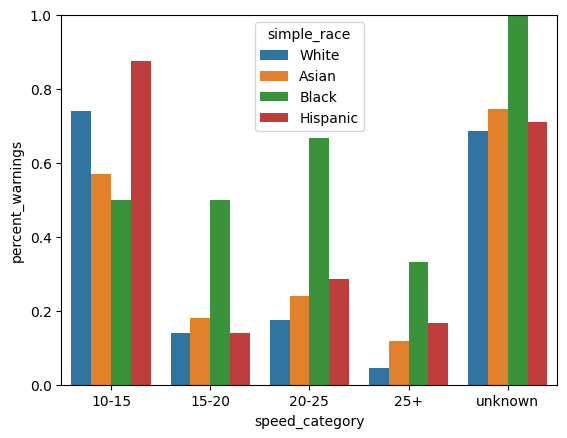

In [342]:
ax = sns.barplot(data=graph_1_df, x="speed_category", y="percent_warnings", hue="simple_race",
                 order=['10-15','15-20', '20-25','25+', 'unknown'])
ax.set_ylim([0, 1])
